In [ ]:
#########################################
# 
# PRINCIPAL COMPONENT ANALYSIS (PCA)
#
#########################################
#
# PCA -> find a low dimensional subspace that approximates the data in sqaured error - representation learning
# Its not -> clustering, class separation, feature selection, denoising(directly), 'lower dimensions are better'
# Assumption -> Directions of highest variance contain the most information about the data-generating process
# 
# Given data matrix X belongs to R (samples x features)
# We want orthonormal directions - v_1,...,v_k that maximize variance of projections of X onto those directions
# max_(norm(v)=1) var(Xv) -> variance maximisation
# min (f_norm(X -ZW_T))   -> reconstruction minimisation
# 
# Preprocessing
# Centering -> first component points towards mean and doesnt give us any real direction of relation between the data points
# so we center it (change the center of data from mean(not necessarily origin) to origin) X -> X - mean
# Scaling -> if features have different units
#
# Covariance matrix of X (already centered // population) -> sigma = 1/n * (X_T) * (X)
# variance along direction v = v_T * sigma * v and we want max of this
# Eigenvectors of covariance matrix show the unique (orthogonal) directions of relations between different data points and eigenvalues the value of those linear relations
# PCA preseves the directions it considers important (the directions of strongest linear relations between the data) only not the actual strucutre of the data itself
# We calculate covariance matrix via SVD (direct operation on X rather than X_T*X in EVD) X = U * sigma * V_T -> V,U - principal components, sigma = sqrt(eigenvalues)
# Project X onto the principal directions -> Z = X*W_k  -> (W_k = [v1,v2...,vk])
# Reconstruct X' = Z*W^T_k  - throw away components orthogonal to the chosen subspace


In [15]:
import numpy as np
from scipy.linalg import svd
from kneed import KneeLocator
import matplotlib.pyplot as plt
def pca(X   ):

    n_samples,n_features = X.shape

    X_centered = X - np.mean(X,axis=0)
    _,singular_values,V_T = svd(X_centered)
    eigenvalues = singular_values**2
    k_opt = KneeLocator(range(len(eigenvalues)),eigenvalues,curve='convex',direction='decreasing')
    k_opt = k_opt.knee if k_opt.knee else 1
    W = V_T[:k_opt]
    EVR = np.sum(eigenvalues[:k_opt]**2/np.sum(eigenvalues))
    X_proj = X_centered @ W.T
    X_recon = X_proj @ W + np.mean(X,axis=0)

    return k_opt,X_recon,singular_values,EVR
    


####################### PCA (anisotropic gaussian) ###############################

K : 1
Singular values : [1.26344832e+04 3.69845616e+01 2.29560773e+00]...
EVR : 159628791.64169675



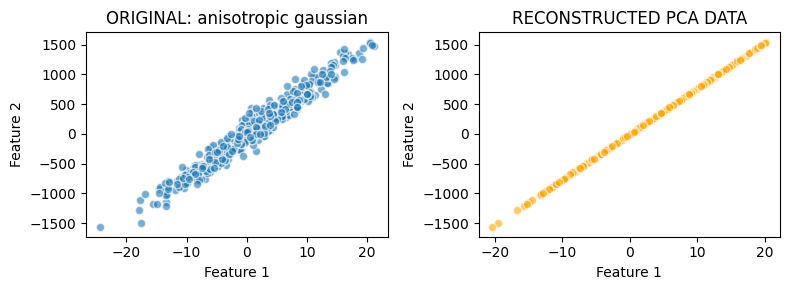

####################### PCA (equal variance noise) ###############################

K : 10
Singular values : [29.21518105 28.1726818  28.04601805 27.52241663 27.06720633]...
EVR : 215.7698551596993



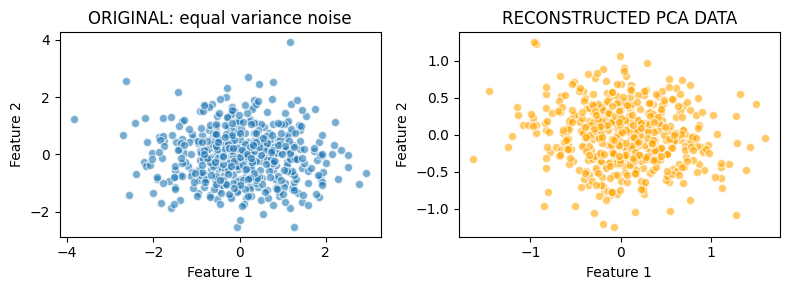

####################### PCA (nonlinear structure) ###############################

K : 1
Singular values : [31.76504091 15.88475973 14.95374854]...
EVR : 685.6200390337633



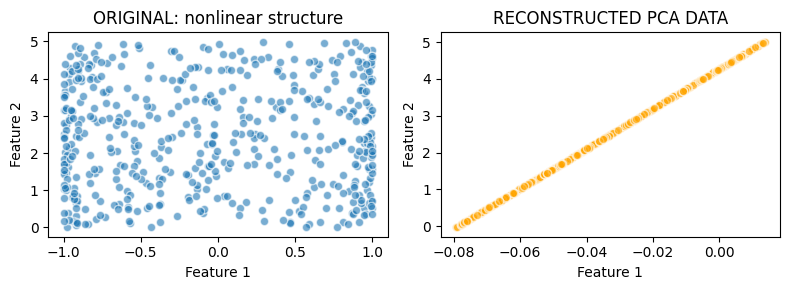

In [50]:
np.random.seed(42)
n_samples = 500

# 1. Anisotropic Gaussian - variance varies by direction (Sensor Data)
raw_sensor = np.random.randn(n_samples, 3) * [10, 1, 0.1]
R = np.array([[0.8, 0.6, 0], [-0.6, 0.8, 0], [0, 0, 1]])
X_sensor = raw_sensor @ R
X_sensor[:,1] = X_sensor[:,1]*100
# 2. Equal-variance noise (High-dim Tabular)
X_tabular = np.random.normal(0, 1, size=(500, 50))

# 3. Nonlinear structure (S-Curve)
t = 1.5 * np.pi * (1 + 2 * np.random.rand(n_samples))
X_manifold = np.vstack((np.sin(t), 5 * np.random.rand(n_samples), np.cos(t))).T

test_cases = [
    ("anisotropic gaussian", X_sensor),
    ("equal variance noise", X_tabular),
    ("nonlinear structure", X_manifold)
]

for name, X in test_cases:
    k_opt, X_recon, singular_values, EVR = pca(X)
    
    print(f"####################### PCA ({name}) ###############################")
    print()
    print(f"K : {k_opt}")
    print(f"Singular values : {singular_values[:5]}...")
    print(f"EVR : {EVR}")
    print()

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))

    ax[0].scatter(X[:, 0], X[:, 1], alpha=0.6, edgecolors='w')
    ax[0].set_xlabel("Feature 1")
    ax[0].set_ylabel("Feature 2") 
    ax[0].set_title(f"ORIGINAL: {name}")

    ax[1].scatter(X_recon[:, 0], X_recon[:, 1], alpha=0.6, edgecolors='w', color='orange')
    ax[1].set_xlabel("Feature 1")
    ax[1].set_ylabel("Feature 2") 
    ax[1].set_title("RECONSTRUCTED PCA DATA")
    
    plt.tight_layout()
    plt.show()

In [ ]:
# In second example with 50 dimensions , it picks K = 10 and those dimensions still contain enough "random spread" of data that the final result also looks like a cloud
# Variance is spread thin across 50 dim thats why this occurs, with 5D variance spread would be more significant for each K and be crushed to almost a single line.
# PCA fails when variance does not equal importance causing it to blindly prioritize features with larger arbitrary scales
# or rotate the entire model to fit a single high-variance outlier